# Code Assignment 19 — Baseline vs. ARIMA on NYC COVID-19 Daily Cases

**Dataset:** NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*  
**Target Variable:** `CASE_COUNT`  
**Goal:** Create a **daily** time series, do a **chronological 80/20 split**, run **ADF on differenced time series be sure to use the TRAIN**, then implement a **Baseline model** and **two ARIMA models** and compare **RMSE**.



## Instructor Guidance (some of these steps will be done for you -- look for the "RUN CELL WITHOUT CHANGES" comment)

**Plan**
1) **Load  CSV** → normalize column names; ensure a proper datetime column.  
2) **Select target** `case_count`; coerce to numeric (strip commas).  
3) **Daily index** + **linear interpolation** (fill small gaps).  
4) **Chronological split (80/20)**: first 80% → TRAIN; last 20% → TEST.  
5) **ADF on differenced TRAIN** (provided).  
6) **Student builds**:
   - **Baseline (shift/naïve)** forecast for TEST; compute **RMSE**.  
   - **ARIMA #1**: pick `(p,d,q)`; fit on TRAIN; forecast into TEST; RMSE.  
   - **ARIMA #2**: pick a different `(p,d,q)`; repeat; RMSE.  
7) **Compare RMSEs** and reflect which model beat baseline and by how much.

**Documentation topics to lookup** 
- `statsmodels.tsa.arima.model.ARIMA`  
- `statsmodels.tsa.stattools.adfuller`  
- `sklearn.metrics.mean_squared_error`

### Step 0:  Import Packages

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

### Step 1:  Load CSV, Keep Needed Columns, Change time column to a datetime object

In [22]:
df = pd.read_csv('/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/covid.csv')

date_col = "date_of_interest"
target_col = "CASE_COUNT"

# Parse date and sort
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col)

# Keep only what we need
df = df[[date_col, target_col]].copy()

df.head()

,date_of_interest,CASE_COUNT
0,2020-02-29,1
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,1
4,2020-03-04,5


### Step 2:  Make a daily series for CASE_COUNT (fill tiny gaps linearly)

In [23]:
s = df.set_index(date_col)[target_col].asfreq("D")

s = pd.to_numeric(s.astype(str).str.replace(",", ""))

s = s.astype("float64")
#Do a linear interpolation on the series 
s_filled = s.interpolate(method='linear')

print("Range:", s.index.min().date(), "→", s.index.max().date(), "| Length:", len(s))
s.head()



Range: 2020-02-29 → 2025-10-13 | Length: 2054


date_of_interest
2020-02-29   1.000
2020-03-01   0.000
2020-03-02   0.000
2020-03-03   1.000
2020-03-04   5.000
Freq: D, Name: CASE_COUNT, dtype: float64

### Step 3: Chronological split: first 80% TRAIN, last 20% TEST

In [24]:
split_idx

1643

Train: 2020-02-29 → 2024-08-28 | n = 1643
Test : 2024-08-29 → 2025-10-13 | n = 411


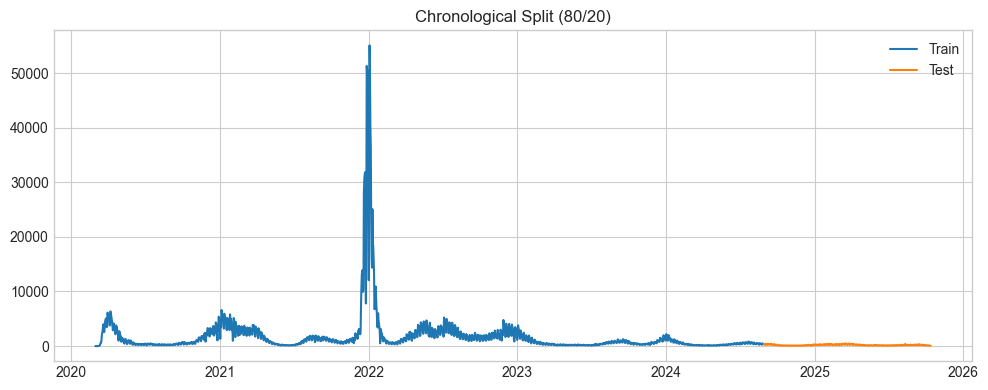

In [4]:
#RUN THIS CELL WITHOUT CHANGES 

split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend()
plt.tight_layout()
plt.show()

### Step 4:  ADF on DIFFERENCED TRAINING data 

In [5]:
# RUN THIS CELL WITHOUT CHANGES

diff_train = train.diff().dropna()
adf_stat, adf_p, _, _, crit, _ = adfuller(diff_train)

print(f"ADF on differenced TRAIN: stat={adf_stat:.3f}, p={adf_p:.4f}")
for k, v in crit.items():
    print(f"  critical {k}: {v:.3f}")
print("\nIf p < 0.05, using d=1 in ARIMA is reasonable.")

ADF on differenced TRAIN: stat=-9.677, p=0.0000
  critical 1%: -3.434
  critical 5%: -2.863
  critical 10%: -2.568

If p < 0.05, using d=1 in ARIMA is reasonable.


### Step 5:  Create a baseline shift model (use a shift of 1) and calculate the RMSE

- Plot the model (Actual vs. Prediction)

Baseline RMSE: 215.047


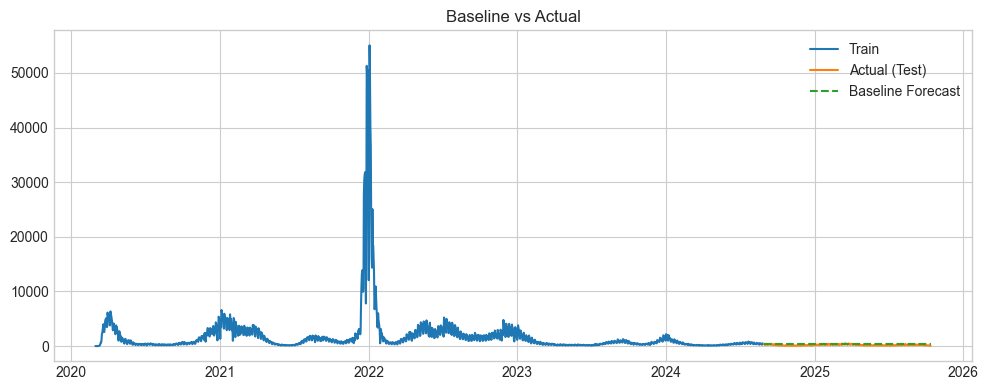

In [6]:
baseline_pred_value = train.iloc[-1]
baseline_preds = pd.Series(baseline_pred_value, index=test.index)
rmse_baseline = np.sqrt(mean_squared_error(test, baseline_preds))
print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(baseline_preds, label="Baseline Forecast", color="#2ca02c", linestyle="--")
plt.title("Baseline vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

### Step 6:  Create an ARIMA (1,1,1) model:  Fit on TRAIN, forecast into TEST, calculate RMSE
- Plot the visual of the model

In [11]:
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
predictions = model_fit.forecast(steps=len(test))

In [12]:
arima_rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"ARIMA(1,1,1) Model RMSE:   {arima_rmse:.2f}")

ARIMA(1,1,1) Model RMSE:   261.13


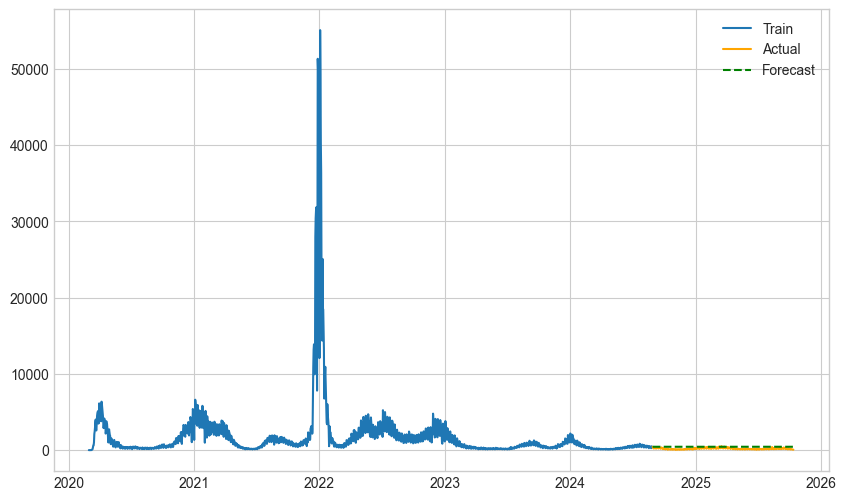

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Actual', color='orange')
plt.plot(predictions, label='Forecast', color='green', linestyle='--')
plt.legend()
plt.show()

### Step 7:  Create an ARIMA(2,1,1):  Fit on TRAIN, forecast into TEST, calculate RMSE
- Plot the visual of the model

In [18]:
model2 = ARIMA(train, order=(2, 1, 1))
model2_fit = model2.fit()
predictions2 = model2_fit.forecast(steps=len(test))

In [19]:
arima_rmse = np.sqrt(mean_squared_error(test, predictions2))
print(f"ARIMA(2,1,1) Model RMSE:   {arima_rmse:.2f}")

ARIMA(2,1,1) Model RMSE:   220.66


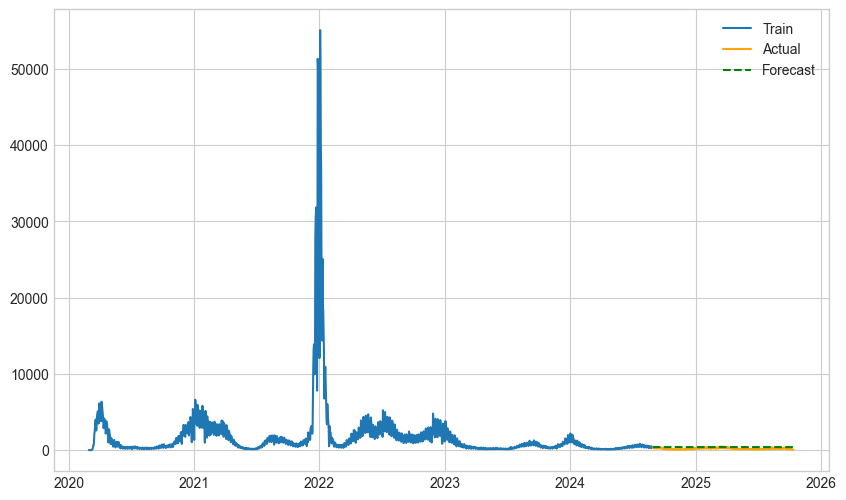

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Actual', color='orange')
plt.plot(predictions2, label='Forecast', color='green', linestyle='--')
plt.legend()
plt.show()

## Reflection (We Share)
- Which ARIMA order performed best vs. baseline? By how much (%) did it reduce RMSE?
- If neither ARIMA beat baseline, what’s your next step (different d, seasonal naïve, SARIMA, widen training window, handle outliers)?


Both ARIMA orders performed worse than the baseline with (2,1,1) being the closest to it being up by 5%. If ARIMA doesn’t beat the baseline, my next step could be trying a seasonal naïve model to see if simple seasonal repetition outperforms ARIMA, or fit a SARIMA, which can capture both trend and seasonality more effectively than a standard ARIMA.